Define Neal's Funnel where $p(x,y) = N(y|0,3) N(x|0,\exp(y/2))$.

In [1]:
from beanmachine.ppl.experimental.tests.vi.neals_funnel import NealsFunnel
nf = NealsFunnel()

Visualize the PDF of Neal's funnel on a grid

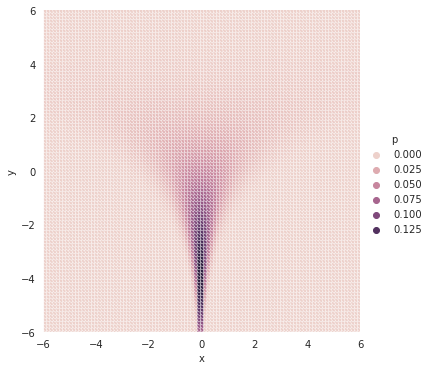

In [2]:
import torch

import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")

xs = torch.linspace(-6,6)
ys = torch.linspace(-6,6)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = nf.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).numpy(),
}), x="x", y="y", hue="p")
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

Draw some samples from Neal's funnel and plot a KDE

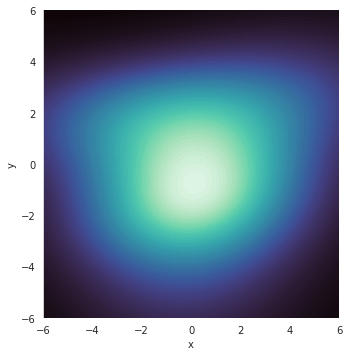

In [3]:
nf_samples = nf.sample(sample_shape=(100,2)).squeeze().numpy()
g = sns.displot(
    data=pd.DataFrame({
        "x": nf_samples[:,0],
        "y": nf_samples[:,1],
    }),
    x="x",
    y="y",
    kind="kde",
    fill=True, thresh=0, levels=100, cmap="mako",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

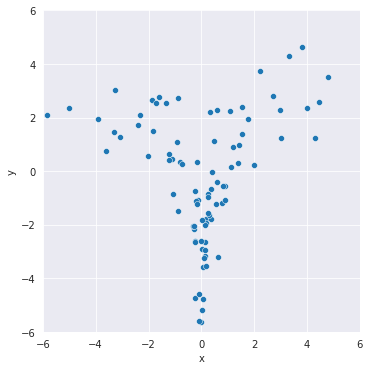

In [4]:
g = sns.relplot(
    data=pd.DataFrame({
        "x": nf_samples[:,0],
        "y": nf_samples[:,1],
    }),
    x="x",
    y="y",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

Try to perform VI using a neural network transform in a reparameterization trick

In [5]:
from beanmachine.ppl.experimental.vi.VariationalInfer import VariationalApproximation

vi = VariationalApproximation(target=nf)
vi.train(epochs=1000)

4.484720230102539
0.7483224272727966
0.5250082612037659
0.6738665699958801
0.4861038327217102
0.4078048765659332
0.47304075956344604
0.46452757716178894
0.40611326694488525
0.40849700570106506


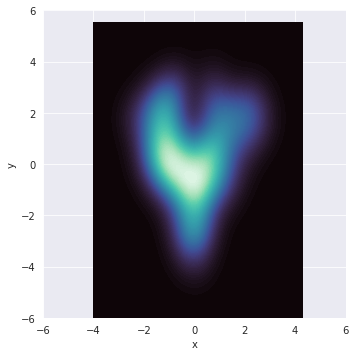

In [6]:
vi_samples = vi.sample((100,2)).detach().numpy()
g = sns.displot(
    data=pd.DataFrame({
        "x": vi_samples[:,0],
        "y": vi_samples[:,1],
    }),
    x="x",
    y="y",
    kind="kde",
    fill=True, thresh=0, levels=100, cmap="mako",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

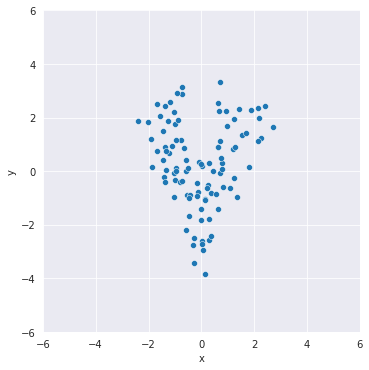

In [7]:
g = sns.relplot(
    data=pd.DataFrame({
        "x": vi_samples[:,0],
        "y": vi_samples[:,1],
    }),
    x="x",
    y="y",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

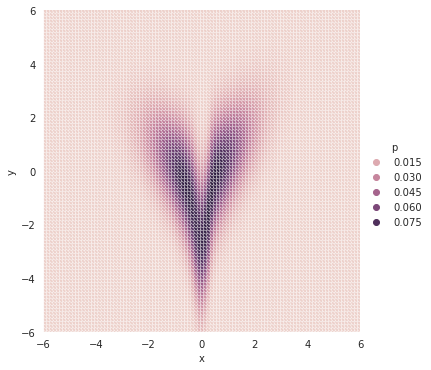

In [8]:
xs = torch.linspace(-6,6)
ys = torch.linspace(-6,6)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = vi.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy(),
}), x="x", y="y", hue="p")
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

In [9]:
import scipy.stats

scipy.stats.ks_2samp(nf_samples[:,1], vi_samples[:,1]).pvalue

0.03638428787491733

In [10]:
scipy.stats.ks_2samp(nf_samples[:,0], vi_samples[:,0])

Ks_2sampResult(statistic=0.16, pvalue=0.1548386665118475)